In this notebook, we're going to explore a dataset of polysomnography data (PSG) from patients in a sleep clinic. The data is taken from a [PhysioNet](https://www.physionet.org/) repository called [Haaglanden Medisch Centrum Sleep Staging Database](https://physionet.org/content/hmc-sleep-staging/1.1/) by Diego Alvarez-Estevez and Roselyne Rijsman.

## Important: Run this code cell each time you start a new session!

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import mne

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [ ]:
subject_list = [f'SN{str(i).zfill(3)}' for i in range(1, 4)]
fs = 256
old_base_folder = os.path.join('physionet.org', 'files', 'hmc-sleep-staging', '1.1', 'recordings')

In [ ]:
for subject in subject_list:
    !wget -rNcnp https://physionet.org/files/hmc-sleep-staging/1.1/recordings/{subject}.edf
    !wget -rNcnp https://physionet.org/files/hmc-sleep-staging/1.1/recordings/{subject}_sleepscoring.edf

--2024-01-04 22:53:51--  https://physionet.org/files/hmc-sleep-staging/1.1/recordings/SN001.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘physionet.org/files/hmc-sleep-staging/1.1/recordings/SN001.edf’ not modified on server. Omitting download.

--2024-01-04 22:53:52--  https://physionet.org/files/hmc-sleep-staging/1.1/recordings/SN001_sleepscoring.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘physionet.org/files/hmc-sleep-staging/1.1/recordings/SN001_sleepscoring.edf’ not modified on server. Omitting download.



In [ ]:
# Make a simple directory to hold the data
if not os.path.exists('data'):
    os.makedirs('data')

# Iterate through the filenames
for subject in subject_list:
    # Load the annotations
    annotations = mne.read_annotations(os.path.join(old_base_folder, f'{subject}_sleepscoring.edf'))
    annotations_data = {
        'onset': annotations.onset,
        'duration': annotations.duration,
        'description': annotations.description
    }

    # Load the data
    edf = mne.io.read_raw_edf(os.path.join(old_base_folder, f'{subject}.edf'))
    df = pd.DataFrame(edf.get_data().T, columns=edf.ch_names)
    df['Time'] = np.arange(0, len(df))*(1/fs)

    # Add the annotations as a new column
    df['Annotation'] = np.nan
    annotations_data = zip(annotations.onset,
                           annotations.duration,
                           annotations.description)
    for onset, duration, description in annotations_data:
        # Skip if annotation relates to lights
        if 'Light' in description:
            continue

        # Add annotation to df
        label = description.split(' ')[-1]
        window_condition = (df['Time'] >= onset) & (df['Time'] < onset+duration)
        df.loc[window_condition, 'Annotation'] = label

    # Clean up the table save
    first_cols = ['Time', 'Annotation']
    new_col_order = first_cols + [col for col in df.columns if col not in first_cols]
    df = df[new_col_order]
    df.dropna(inplace=True)
    df.to_csv(os.path.join('data', f'{subject}.csv'), index=False)

Extracting EDF parameters from /content/physionet.org/files/hmc-sleep-staging/1.1/recordings/SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [ ]:
df

,Time,Annotation,EEG F4-M1,EEG C4-M1,EEG O2-M1,EEG C3-M2,EMG chin,EOG E1-M2,EOG E2-M2,ECG
0,0.000000,W,0.000017,0.000015,0.000038,0.000006,-4.528878e-06,0.000004,-0.000009,0.000074
1,0.003906,W,0.000018,0.000016,0.000037,0.000005,1.403830e-06,0.000011,-0.000011,0.000071
2,0.007812,W,0.000018,0.000011,0.000024,0.000008,2.319371e-07,0.000022,-0.000010,0.000069
3,0.011719,W,0.000011,0.000003,0.000013,0.000006,-2.319371e-07,0.000027,-0.000011,0.000065
4,0.015625,W,0.000006,0.000002,0.000018,0.000003,2.868696e-06,0.000026,-0.000015,0.000058
...,...,...,...,...,...,...,...,...,...,...
6558715,25619.980469,W,-0.000132,-0.000122,-0.000116,-0.000030,-6.823835e-06,0.000007,-0.000037,0.000104
6558716,25619.984375,W,-0.000136,-0.000141,-0.000138,-0.000045,8.313115e-06,0.000021,-0.000030,0.000102
6558717,25619.988281,W,-0.000128,-0.000124,-0.000113,-0.000024,5.114824e-06,0.000016,-0.000016,0.000123
6558718,25619.992188,W,-0.000114,-0.000093,-0.000072,-0.000004,1.556420e-05,-0.000011,-0.000029,0.000055


# Instructions

To get full credit for this assignment, we should be able to run your entire notbook from start to finish without any errors. You can check this yourself by selecting "Runtime" > "Run all" in the Google Colab menu.

# Overview of the Dataset

There are several stages of sleep that occur in a cycle throughout the night. For the sake of this dataset, sleep can be divided into the following stages: awake (W), light sleep (N1), intermediate sleep (N2), deep sleep (N3), and REM sleep (R). Each stage of sleep plays an important role in the overall health and well-being of an individual. Therefore, sleep stage classification is a useful technique for diagnosing sleep disorders.

The goal of this dataset is to enable researchers to automatically identify sleep stages using polysomnographic (PSG) recordings. Given the large size of these recordings, we will work only work with data from 3 participants from this 151-person study. Patient recordings were randomly selected from a heterogeneous group of patients who were referred for PSG examination due to different sleep disorders.

Participants were instrumented with the minimal recommended set of sensors necessary to visually score sleep stages: four EEG (F4/M1, C4/M1, O2/M1, and C3/M2), two EOG (E1/M2 and E2/M2), one bipolar chin EMG, and one ECG (single modified lead II) data stream. Participants slept in the sleep clinic for one night. Their PSG recordings were reviewed and annotated by expert clinicians according to discrete 30-second windows. An example of this annotation process is shown below (note: this is merely an illustration and does not represent the true time-scale of the data):

<img src="https://drive.google.com/uc?id=1UnkMe1WmP813ZGyS7ynT_CMqP2Nr2do0" width=750px/>

All data was recorded at 256 Hz. For your convenience, the data has already been processed so that there is one `.csv` per participant in a folder called `data` with the following naming convention: `SN{subject_id}.csv`. These files have the following columns:

| Column # | Description |
|----------|-------------|
| 1 | Time in seconds|
| 2 | Annotation given by the sleep experts (W, N1, N2, N3, R) |
| 3–6 | EEG data |
| 7 | EMG data |
| 8–9 | EOG data |
| 10 | ECG data |

In [ ]:
# The relevant folders and files associated with this dataset
base_folder = 'data'

In this notebook, your goal will be to summarize the sensor data within each 30-second window in a way that makes it easy to discriminate between epochs during different sleep stages.

# Inspecting the Dataset

For this part of the notebook, your task is to complete some helper functions that will help you load and examine the dataset. An example `DataFrame` and some commands for testing these functions have been provided for you.

In [ ]:
df = pd.read_csv(os.path.join(base_folder, f'{subject_list[0]}.csv'))

**(Part 1)** Complete the function below so that it grabs a single 30-second window of data from a DataFrame `df` starting from `start_time`. The function should also return the annotation associated with that window.

In [ ]:
from numpy.fft import fftfreq
from scipy.fftpack import fft
from scipy import signal
def grab_window(df, start_time):
    """
    Grab a 30-second window of data from start_time to start_time+30
    df: the DataFrame
    start_time: the start of the window in seconds (must be a multiple of 30)
    """
    # Check the inputs
    if start_time % 30 != 0:
        raise Exception('start_time should be a multiple of 30')

    # Get the data window of interest
    subset_condition = (df['Time'] >= start_time) & (df['Time'] < start_time+30)
    window_df = df[subset_condition]

    # Get the annotation associated with the window
    # Note: this works since the annnotation is the same for
    # all rows in a 30-second chunk
    annotation = window_df['Annotation'].values[0]
    return window_df, annotation

In [ ]:
window_df, annotation = grab_window(df, 0)
print(f'Annotation: {annotation}')
window_df

Annotation: W


,Time,Annotation,EEG F4-M1,EEG C4-M1,EEG O2-M1,EEG C3-M2,EMG chin,EOG E1-M2,EOG E2-M2,ECG
0,0.000000,W,0.000017,0.000015,0.000038,5.896086e-06,-4.528878e-06,0.000004,-0.000009,0.000074
1,0.003906,W,0.000018,0.000016,0.000037,5.456626e-06,1.403830e-06,0.000011,-0.000011,0.000071
2,0.007812,W,0.000018,0.000011,0.000024,7.580682e-06,2.319371e-07,0.000022,-0.000010,0.000069
3,0.011719,W,0.000011,0.000003,0.000013,6.433204e-06,-2.319371e-07,0.000027,-0.000011,0.000065
4,0.015625,W,0.000006,0.000002,0.000018,3.381399e-06,2.868696e-06,0.000026,-0.000015,0.000058
...,...,...,...,...,...,...,...,...,...,...
7675,29.980469,W,0.000028,0.000019,0.000030,-8.606088e-06,1.379416e-06,-0.000018,-0.000023,-0.000385
7676,29.984375,W,0.000030,0.000022,0.000030,-5.749599e-06,2.307164e-06,-0.000013,-0.000017,-0.000234
7677,29.988281,W,0.000023,0.000014,0.000015,-2.722210e-06,3.356985e-06,-0.000003,-0.000012,-0.000091
7678,29.992188,W,0.000025,0.000010,0.000008,7.446403e-07,8.422980e-07,0.000004,-0.000011,0.000015


In [ ]:
window_df, annotation = grab_window(df, 30*100)
print(f'Annotation: {annotation}')
window_df

Annotation: N2


,Time,Annotation,EEG F4-M1,EEG C4-M1,EEG O2-M1,EEG C3-M2,EMG chin,EOG E1-M2,EOG E2-M2,ECG
768000,3000.000000,N2,-1.815213e-05,-1.143816e-05,-0.000009,-1.190204e-05,1.013199e-06,0.000006,-0.000010,0.000001
768001,3000.003906,N2,-1.824979e-05,-1.070573e-05,-0.000011,-1.195087e-05,-4.821851e-06,0.000007,-0.000014,0.000007
768002,3000.007812,N2,-2.235142e-05,-1.602808e-05,-0.000018,-1.817655e-05,-8.667124e-07,0.000003,-0.000017,0.000008
768003,3000.011719,N2,-2.613565e-05,-2.132601e-05,-0.000023,-2.310826e-05,-3.283742e-06,0.000001,-0.000017,0.000011
768004,3000.015625,N2,-2.594034e-05,-2.171664e-05,-0.000020,-2.139925e-05,-1.745632e-06,0.000005,-0.000013,0.000005
...,...,...,...,...,...,...,...,...,...,...
775675,3029.980469,N2,-1.353780e-05,-1.053483e-05,-0.000002,-5.236896e-06,4.748608e-06,0.000011,-0.000026,0.000041
775676,3029.984375,N2,-7.824826e-06,-5.163653e-06,0.000004,3.051804e-07,-7.202258e-07,0.000014,-0.000025,0.000040
775677,3029.988281,N2,-2.771038e-06,9.887846e-07,0.000009,5.798428e-06,1.721218e-06,0.000015,-0.000024,0.000044
775678,3029.992188,N2,-4.516670e-07,3.064012e-06,0.000007,5.578698e-06,1.525902e-06,0.000012,-0.000026,0.000043


**(Part 2)** Complete the function below so that it takes in a 30-second window of data and displays the data from a single column `sensor`as both as a time-series signal (signal over time) and as a spectrogram (frequency over time heatmap).

In [ ]:
from numpy.fft import fftfreq
from scipy.fftpack import fft
from scipy import signal
def view_recording(window_df, sensor):
    """
    Displays data in the sensor column as a time-domain signal and as a spectrogram
    window_df: the 30-second DataFrame
    sensor: the name of the sensor column to be displayed
    """
    # Check the inputs
    window_length = window_df['Time'].max()-window_df['Time'].min()
    if window_length > 30:
        raise Exception('Please only provide a 30-second window')
    if sensor not in list(df.columns):
        raise Exception('Sensor not found')

    # Grab the data
    time = window_df['Time'].values
    values = window_df[sensor].values

    # Calculate the spectrogram
    values_centered = values - values.mean()
    spec_freqs, spec_times, spectro = signal.spectrogram(values_centered, fs)

    # Show the two signal representations
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title('Time Domain')
    plt.plot(time, values)
    plt.xlabel('Time (s)'), plt.ylabel(sensor)

    plt.subplot(1, 2, 2)
    plt.title('Frequency Domain: Spectrogram')
    plt.pcolormesh(spec_times, spec_freqs, spectro, shading='gouraud')
    plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 30)
    plt.show()

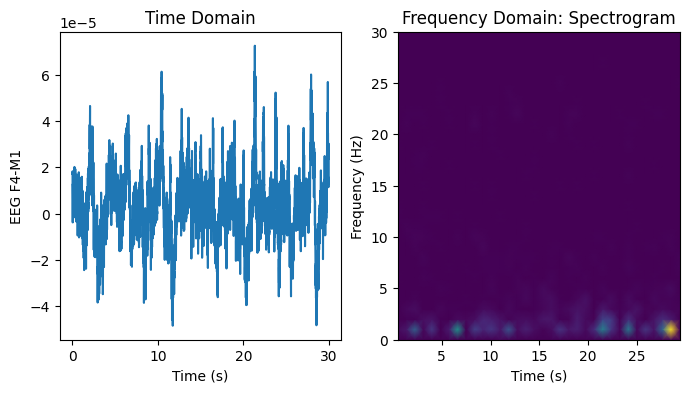

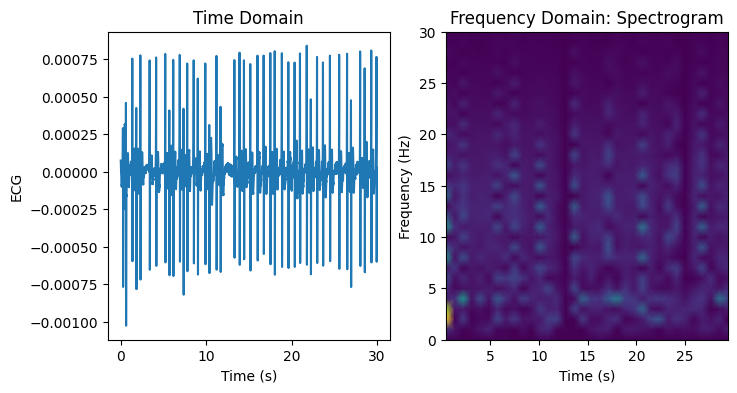

In [ ]:
window_df, _ = grab_window(df, 0)
view_recording(window_df, 'EEG F4-M1')
view_recording(window_df, 'ECG')

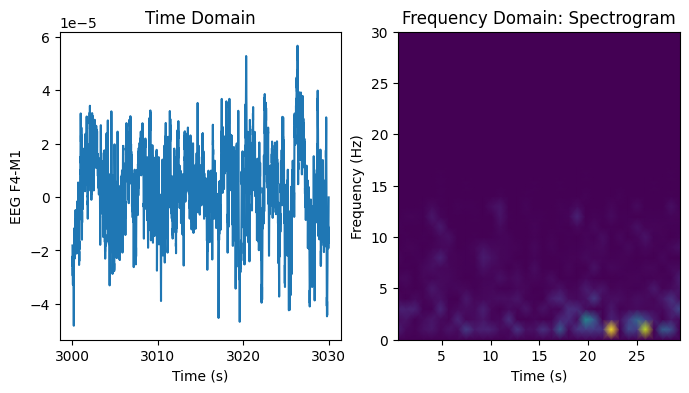

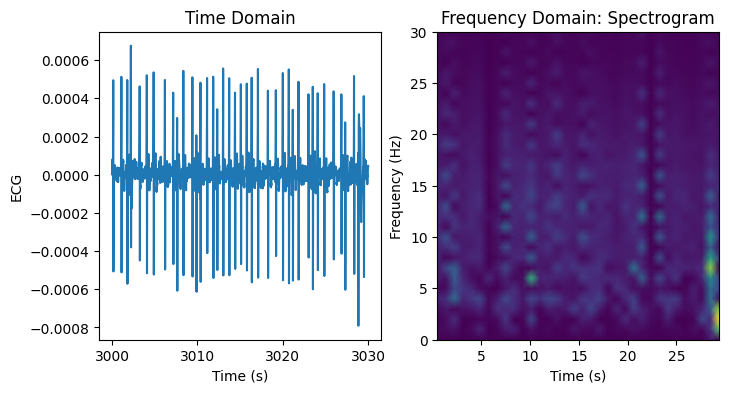

In [ ]:
window_df, _ = grab_window(df, 30*100)
view_recording(window_df, 'EEG F4-M1')
view_recording(window_df, 'ECG')

# Extracting Information from a Recording

For this part of the notebook, your task is to create functions that will process the sensor data within a given 30-second window into a compact representation that will make it easier for us to compare windows across different sleep stages. It is up to you to decide the kind of information you want to extract from each window, but here are some pieces of advice:
* Examine the data using the `view_recording()` function you created earlier to see if you notice any interesting trends in the data.
* If you don't know where to start, consider using basic time-domain and frequency-domain metrics that we discussed in class.
* It is okay to use the same metrics for each sensor.

You may use the following window to test your functions:

In [ ]:
window_df, _ = grab_window(df, 30*100)

Each function should return a `dict` of the following form:
```
{'metric name 1': 0.0000,
'metric name 2': 0.0000,
...}
```

**(Part 1)** Complete the function below to summarize the four columns of EEG data within a 30-second window.

In [ ]:
def compute_eeg_metrics(window_df, fs=256):
    """
    Returns a dictionary of metrics that summarize the EEG data in the DataFrame
    df: the DataFrame
    fs: the sampling rate
    """
    # Grab the time data
    eeg_ch = ['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1', 'EEG C3-M2']
    time = window_df['Time'].values

    # Initialize the dictionary
    info_dict = {}

    # Iterate through the EEG channels and perform time- and frequency-domain calculations
    for eeg_name in eeg_ch:
        eeg = window_df[eeg_name].values
        # Time domain
        info_dict[f'{eeg_name} mean'] = eeg.mean()
        info_dict[f'{eeg_name} stdev'] = eeg.std()

        # Frequency domain
        eeg_centered = eeg - eeg.mean()
        fft_mag = np.abs(fft(eeg_centered))
        fft_freqs = fftfreq(len(eeg_centered), 1/fs)
        info_dict[f'{eeg_name} peak freq'] = fft_freqs[fft_mag.argmax()]

    # Add time-domain features for overall EEG
    eeg = np.sqrt(sum([window_df[eeg_name].values**2
                       for eeg_name in eeg_ch]))
    info_dict[f'EEG mean'] = eeg.mean()

    # Return a dictionary of calculations
    return info_dict

In [ ]:
compute_eeg_metrics(window_df)

{'EEG F4-M1 mean': 3.1508608631520053e-06,
 'EEG F4-M1 stdev': 1.5045799393721486e-05,
 'EEG F4-M1 peak freq': 0.2,
 'EEG C4-M1 mean': -9.122351923908327e-08,
 'EEG C4-M1 stdev': 1.4426841435849845e-05,
 'EEG C4-M1 peak freq': 0.3333333333333333,
 'EEG O2-M1 mean': 2.9989064367640697e-06,
 'EEG O2-M1 stdev': 1.2564666667761896e-05,
 'EEG O2-M1 peak freq': 0.3333333333333333,
 'EEG C3-M2 mean': -5.1962437374430965e-06,
 'EEG C3-M2 stdev': 1.4529539854053572e-05,
 'EEG C3-M2 peak freq': 0.26666666666666666,
 'EEG mean': 2.5960461298941136e-05}

**(Part 2)** Complete the function below to summarize the single column of EMG data within a 30-second window.

In [ ]:
def compute_emg_metrics(window_df, fs=256):
    """
    Returns a dictionary of metrics that summarize the EMG data in the DataFrame
    df: the DataFrame
    fs: the sampling rate
    """
    # Grab the data
    time = window_df['Time'].values
    emg = window_df['EMG chin'].values
    info_dict = {}

    # Time domain
    info_dict[f'EMG mean'] = emg.mean()
    info_dict[f'EMG stdev'] = emg.std()

    # Frequency domain
    emg_centered = emg - emg.mean()
    fft_mag = np.abs(fft(emg_centered))
    fft_freqs = fftfreq(len(emg_centered), 1/fs)
    info_dict[f'EMG peak freq'] = fft_freqs[fft_mag.argmax()]

    # Return a dictionary of calculations
    return info_dict

In [ ]:
compute_emg_metrics(window_df)

{'EMG mean': 1.6329982706441848e-06,
 'EMG stdev': 1.9393428695734563e-06,
 'EMG peak freq': 0.5}

**(Part 3)** Complete the function below to summarize the two columns of EOG data within a 30-second window.

In [ ]:
def compute_eog_metrics(window_df, fs=256):
    """
    Returns a dictionary of metrics that summarize the EOG data in the DataFrame
    df: the DataFrame
    fs: the sampling rate
    """
    # Grab the time data
    eog_ch = ['EOG E1-M2', 'EOG E2-M2']
    time = window_df['Time'].values

    # Initialize the dictionary
    info_dict = {}

    # Iterate through the EEG channels and perform time- and frequency-domain calculations
    for eog_name in eog_ch:
        eog = window_df[eog_name].values
        # Time domain
        info_dict[f'{eog_name} mean'] = eog.mean()
        info_dict[f'{eog_name} stdev'] = eog.std()

        # Frequency domain
        eog_centered = eog - eog.mean()
        fft_mag = np.abs(fft(eog_centered))
        fft_freqs = fftfreq(len(eog_centered), 1/fs)
        info_dict[f'{eog_name} peak freq'] = fft_freqs[fft_mag.argmax()]

    # Add time-domain features for overall EEG
    eog = np.sqrt(sum([window_df[eog_name].values**2
                       for eog_name in eog_ch]))
    info_dict[f'EOG mean'] = eog.mean()

    # Return a dictionary of calculations
    return info_dict

In [ ]:
compute_eog_metrics(window_df)

{'EOG E1-M2 mean': -3.041692098369828e-06,
 'EOG E1-M2 stdev': 1.206454658562348e-05,
 'EOG E1-M2 peak freq': 0.36666666666666664,
 'EOG E2-M2 mean': -4.390433864855929e-06,
 'EOG E2-M2 stdev': 1.2829028258854251e-05,
 'EOG E2-M2 peak freq': 0.26666666666666666,
 'EOG mean': 1.5325098033836664e-05}

**(Part 4)** Complete the function below to summarize the single column of ECG data within a 30-second window.

In [ ]:
def compute_ecg_metrics(window_df, fs=256):
    """
    Returns a dictionary of metrics that summarize the ECG data in the DataFrame
    df: the DataFrame
    fs: the sampling rate
    """
    # Grab the data
    time = window_df['Time'].values
    ecg = window_df['ECG'].values
    info_dict = {}

    # Time domain
    info_dict[f'ECG mean'] = ecg.mean()
    info_dict[f'ECG stdev'] = ecg.std()

    # Frequency domain
    ecg_centered = ecg - ecg.mean()
    fft_mag = np.abs(fft(ecg_centered))
    fft_freqs = fftfreq(len(ecg_centered), 1/fs)
    info_dict[f'ECG peak freq'] = fft_freqs[fft_mag.argmax()]

    # Return a dictionary of calculations
    return info_dict

In [ ]:
compute_ecg_metrics(window_df)

{'ECG mean': 7.462758449682718e-06,
 'ECG stdev': 0.00010839850992378587,
 'ECG peak freq': 8.6}

**(Part 5)** If all of the functions above are complete, then you should be able to run the following function below to produce a single `dict` that includes the metrics across all sensors for a given `DataFrame`:

In [ ]:
def process_window(window_df):
    """
    Process a DataFrame and produce all of the metrics as a dictionary
    (one value per key)
    window_df: the DataFrame
    """
    # Extract metrics
    eeg_dict = compute_eeg_metrics(window_df)
    emg_dict = compute_emg_metrics(window_df)
    eog_dict = compute_eog_metrics(window_df)
    ecg_dict = compute_ecg_metrics(window_df)

    # Combine everything into a single dictionary
    final_dict = {}
    final_dict.update(eeg_dict)
    final_dict.update(emg_dict)
    final_dict.update(eog_dict)
    final_dict.update(ecg_dict)

    # Check that the keys are unique from the original metrics
    if len(final_dict) != len(eeg_dict) + len(emg_dict) + len(eog_dict) + len(ecg_dict):
        raise Exception('Make sure the keys of your dictionaries are unique')
    return final_dict

In [ ]:
# Test our function
process_window(window_df)

{'EEG F4-M1 mean': 3.1508608631520053e-06,
 'EEG F4-M1 stdev': 1.5045799393721486e-05,
 'EEG F4-M1 peak freq': 0.2,
 'EEG C4-M1 mean': -9.122351923908327e-08,
 'EEG C4-M1 stdev': 1.4426841435849845e-05,
 'EEG C4-M1 peak freq': 0.3333333333333333,
 'EEG O2-M1 mean': 2.9989064367640697e-06,
 'EEG O2-M1 stdev': 1.2564666667761896e-05,
 'EEG O2-M1 peak freq': 0.3333333333333333,
 'EEG C3-M2 mean': -5.1962437374430965e-06,
 'EEG C3-M2 stdev': 1.4529539854053572e-05,
 'EEG C3-M2 peak freq': 0.26666666666666666,
 'EEG mean': 2.5960461298941136e-05,
 'EMG mean': 1.6329982706441848e-06,
 'EMG stdev': 1.9393428695734563e-06,
 'EMG peak freq': 0.5,
 'EOG E1-M2 mean': -3.041692098369828e-06,
 'EOG E1-M2 stdev': 1.206454658562348e-05,
 'EOG E1-M2 peak freq': 0.36666666666666664,
 'EOG E2-M2 mean': -4.390433864855929e-06,
 'EOG E2-M2 stdev': 1.2829028258854251e-05,
 'EOG E2-M2 peak freq': 0.26666666666666666,
 'EOG mean': 1.5325098033836664e-05,
 'ECG mean': 7.462758449682718e-06,
 'ECG stdev': 0.00

# Creating Our Processed Dataset

For this part of the notebook, simply run the code below to create your final dataset. This will take a long time because the recordings are long. When the code is done running, notice how each window corresponds to a single row.

In [ ]:
# Iterate through the subject IDs
df = pd.DataFrame()
for subject in subject_list:
    # Load the DataFrame
    subject_df = pd.read_csv(os.path.join(base_folder, f'{subject}.csv'))

    # Iterate through all windows
    window_starts = np.arange(0, subject_df['Time'].max(), 30)
    for window_start in window_starts:
        # Grab the window
        window_df, annotation = grab_window(subject_df, window_start)

        # Process the window
        result_dict = process_window(window_df)

        # Add it to the final DataFrame
        result_dict['Subject ID'] = subject
        result_dict['Start Time'] = window_start
        result_dict['Annotation'] = annotation

        result_df = pd.DataFrame([result_dict])
        df = pd.concat([df, result_df], axis=0)

In [ ]:
first_cols = ['Subject ID', 'Start Time', 'Annotation']
new_col_order = first_cols + [col for col in df.columns if col not in first_cols]
df = df[new_col_order]
df

,Subject ID,Start Time,Annotation,EEG F4-M1 mean,EEG F4-M1 stdev,EEG F4-M1 peak freq,EEG C4-M1 mean,EEG C4-M1 stdev,EEG C4-M1 peak freq,EEG O2-M1 mean,...,EOG E1-M2 mean,EOG E1-M2 stdev,EOG E1-M2 peak freq,EOG E2-M2 mean,EOG E2-M2 stdev,EOG E2-M2 peak freq,EOG mean,ECG mean,ECG stdev,ECG peak freq
0,SN001,0.0,W,0.000003,0.000016,0.233333,-3.865682e-07,0.000011,50.033333,0.000003,...,-0.000003,0.000023,0.266667,-0.000005,0.000015,0.233333,0.000024,0.000007,0.000158,14.733333
0,SN001,30.0,W,0.000003,0.000014,0.266667,1.609191e-08,0.000011,50.033333,0.000003,...,-0.000003,0.000022,0.166667,-0.000004,0.000015,0.300000,0.000024,0.000008,0.000151,3.666667
0,SN001,60.0,W,0.000003,0.000010,0.266667,-5.771598e-07,0.000010,50.033333,0.000003,...,-0.000003,0.000021,0.366667,-0.000005,0.000014,0.300000,0.000022,0.000007,0.000152,4.066667
0,SN001,90.0,W,0.000003,0.000011,0.233333,-8.151497e-08,0.000010,50.033333,0.000003,...,-0.000003,0.000019,50.033333,-0.000005,0.000013,0.366667,0.000021,0.000008,0.000155,2.600000
0,SN001,120.0,W,0.000003,0.000011,0.200000,-1.398839e-07,0.000010,50.033333,0.000003,...,-0.000003,0.000018,50.033333,-0.000004,0.000017,0.366667,0.000022,0.000007,0.000152,3.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,SN001,25470.0,W,0.000004,0.000019,0.400000,-1.787954e-06,0.000021,0.366667,0.000003,...,-0.000003,0.000016,0.233333,-0.000005,0.000014,0.533333,0.000018,0.000008,0.000103,4.133333
0,SN001,25500.0,W,0.000004,0.000029,0.400000,4.961757e-07,0.000021,0.333333,0.000004,...,-0.000003,0.000016,0.266667,-0.000005,0.000013,0.266667,0.000019,0.000007,0.000105,2.766667
0,SN001,25530.0,W,0.000004,0.000038,0.333333,-2.429173e-07,0.000038,0.233333,0.000003,...,-0.000003,0.000010,0.300000,-0.000005,0.000009,50.000000,0.000012,0.000007,0.000105,4.133333
0,SN001,25560.0,W,0.000004,0.000020,0.233333,5.024669e-08,0.000018,50.000000,0.000003,...,-0.000003,0.000013,0.300000,-0.000005,0.000012,0.533333,0.000016,0.000007,0.000106,4.100000


# Exploring Our PSG Data Characteristics

For this part of the notebook, your task is to use the techniques we discussed in class to the various techniques we discussed in class (e.g., descriptive statistics, histograms) to investigate whether the window characteristics you calculated are useful for discriminating different sleep stages.

You do not need to look at every single metric using every analysis technique. However, it is important that you are able to show that you come away from this homework feeling comfortable that at least a few of your metrics are discriminative since you will use this dataset in later assignments. If none of your metrics are discriminative, then you should consider extracting different metrics from the windows.

For your convenience, the code below retrieves the names of all of your metrics:

In [ ]:
metrics = list(filter(lambda x: x not in first_cols, df.columns))
metrics

['EEG F4-M1 mean',
 'EEG F4-M1 stdev',
 'EEG F4-M1 peak freq',
 'EEG C4-M1 mean',
 'EEG C4-M1 stdev',
 'EEG C4-M1 peak freq',
 'EEG O2-M1 mean',
 'EEG O2-M1 stdev',
 'EEG O2-M1 peak freq',
 'EEG C3-M2 mean',
 'EEG C3-M2 stdev',
 'EEG C3-M2 peak freq',
 'EEG mean',
 'EMG mean',
 'EMG stdev',
 'EMG peak freq',
 'EOG E1-M2 mean',
 'EOG E1-M2 stdev',
 'EOG E1-M2 peak freq',
 'EOG E2-M2 mean',
 'EOG E2-M2 stdev',
 'EOG E2-M2 peak freq',
 'EOG mean',
 'ECG mean',
 'ECG stdev',
 'ECG peak freq']

**(Part 1)** Calculate the average and standard deviation of your metrics within each sleep stage. For the sake of readability, you do not need to show these statistics for every single metric.

In [ ]:
df_w = df[df['Annotation'] == 'W']
df_n1 = df[df['Annotation'] == 'N1']
df_n2 = df[df['Annotation'] == 'N2']
df_n3 = df[df['Annotation'] == 'N3']
df_r = df[df['Annotation'] == 'R']

In [ ]:
for col in metrics[:5]:
    print(col)
    print(f'W: {df_w[col].mean()} ± {df_w[col].std()}')
    print(f'N1: {df_n1[col].mean()} ± {df_n1[col].std()}')
    print(f'N2: {df_n2[col].mean()} ± {df_n2[col].std()}')
    print(f'N3: {df_n3[col].mean()} ± {df_n3[col].std()}')
    print(f'R: {df_r[col].mean()} ± {df_r[col].std()}')
    print('------------------')

EEG F4-M1 mean
W: 3.6891430711828575e-06 ± 3.3060525669184515e-06
N1: 3.817551765765026e-06 ± 1.7124307438982286e-06
N2: 3.659880675040183e-06 ± 5.851813260002265e-07
N3: 3.4781467033325065e-06 ± 4.178217698878419e-07
R: 3.8008137603910654e-06 ± 1.3784312143893638e-06
------------------
EEG F4-M1 stdev
W: 4.099231411405374e-05 ± 5.856712073580743e-05
N1: 2.8950773280556296e-05 ± 3.8321716232248967e-05
N2: 1.998413214016902e-05 ± 8.936559925473809e-06
N3: 2.2397284199954974e-05 ± 5.215002297212141e-06
R: 2.248969183390852e-05 ± 1.5395492469495346e-05
------------------
EEG F4-M1 peak freq
W: 1.0019867549668873 ± 5.70107622300949
N1: 2.587461773700306 ± 10.445798561737815
N2: 3.032170542635659 ± 11.182891120449185
N3: 0.3811594202898551 ± 0.17315436184489055
R: 0.3574468085106383 ± 0.14382012481307885
------------------
EEG C4-M1 mean
W: -6.689811621822546e-08 ± 1.0480201366727847e-06
N1: 5.023973463299448e-07 ± 2.8436264152404227e-06
N2: -1.2433441387885976e-10 ± 7.006695442642348e-07
N

**(Part 2)** Generate histograms showing how the distribution of your metrics differ across sleep stages. For the sake of readability, you do not need to show these statistics for every single metric.

In [ ]:
def compare_histograms(df, col):
    plt.figure(figsize=(8,4))
    grouped_df = df.groupby('Annotation')[col]
    grouped_df.plot.hist(bins=20, alpha=0.7, legend=True)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col}')
    plt.show()

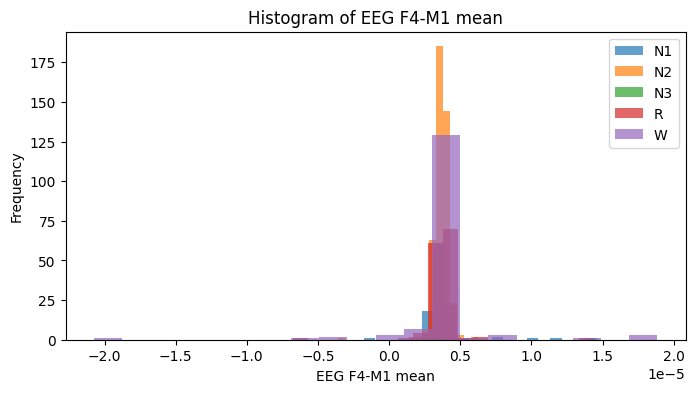

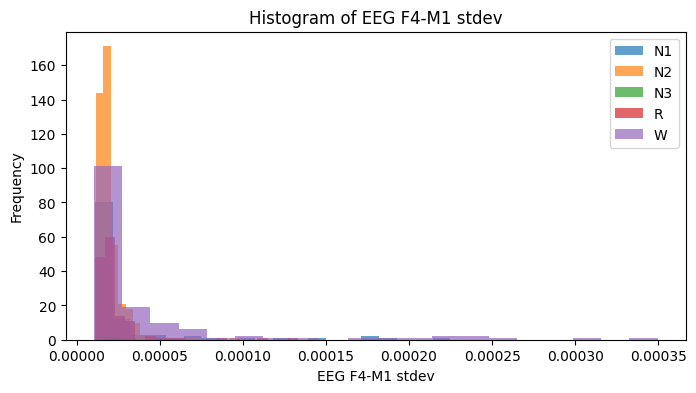

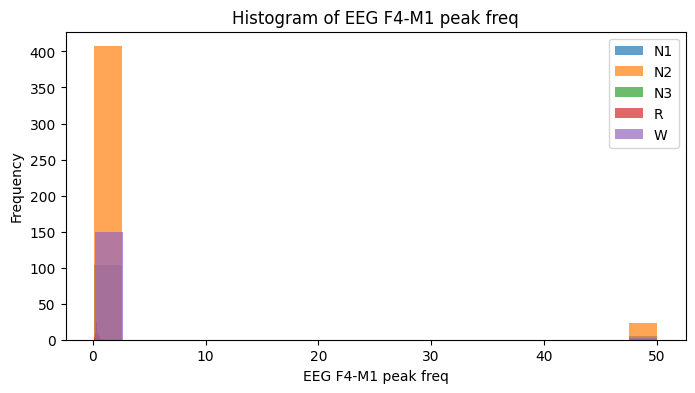

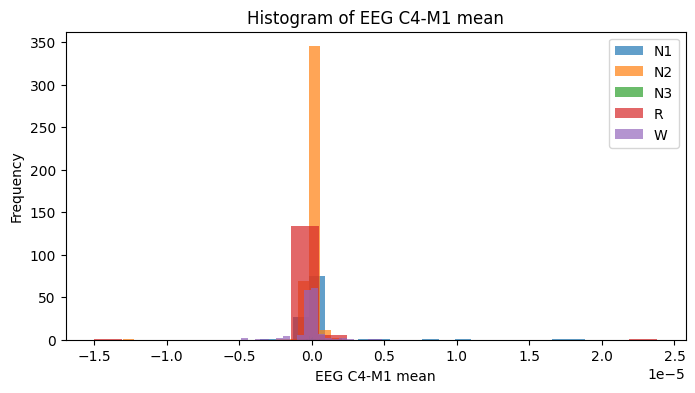

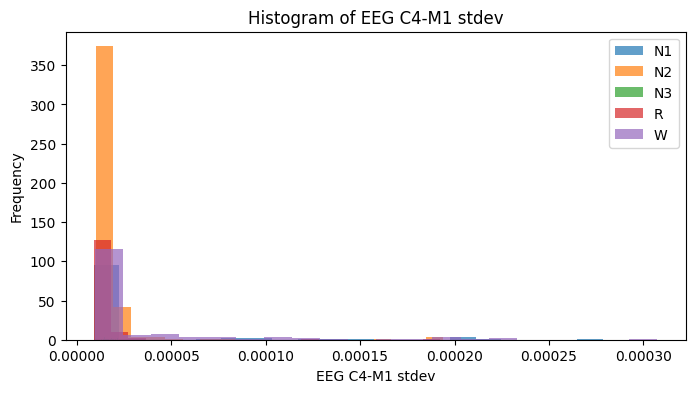

In [ ]:
for col in metrics[:5]:
    compare_histograms(df, col)

**(Part 3)** The following code has already been written for your to conduct statistical tests comparing your metrics across sleep stages. Notice that the code uses different statistical tests than the ones we did in class: ANOVA instead of a t-test and a Kruskal-Wallis instead of a Mann-Whitney U test. This is because we have more than two categories that we are interested in comparing.

Run this code to determine whether or not any of your metrics are significantly different across sleep stages.

In [ ]:
from scipy import stats

def compare_distributions(df, col):
    # Get the relevant data
    data = df[col]
    df_w_data = df[df['Annotation'] == 'W'][col]
    df_n1_data = df[df['Annotation'] == 'N1'][col]
    df_n2_data = df[df['Annotation'] == 'N2'][col]
    df_n3_data = df[df['Annotation'] == 'N3'][col]
    df_r_data = df[df['Annotation'] == 'R'][col]

    # Check of the data is normally distributed
    statistic, p_value = stats.normaltest(data)
    test = None
    if p_value > 0.05:
        # Data is normally distributed, use ANOVA
        test = 'ANOVA'
        statistic, p_value = stats.f_oneway(df_w_data, df_n1_data, df_n2_data, df_n3_data, df_r_data)
    else:
        # Data is not normally distributed, use Kruskal-Wallis Test
        test = 'Kruskal-Wallis'
        statistic, p_value = stats.kruskal(df_w_data, df_n1_data, df_n2_data, df_n3_data, df_r_data)

    print(f'Result of {test} for {col}: {statistic}, p-value is {p_value:0.3f}')

In [ ]:
for col in metrics[:5]:
    compare_distributions(df, col)

Result of Kruskal-Wallis for EEG F4-M1 mean: 17.22205559544045, p-value is 0.002
Result of Kruskal-Wallis for EEG F4-M1 stdev: 27.774697746127913, p-value is 0.000
Result of Kruskal-Wallis for EEG F4-M1 peak freq: 9.973792714983515, p-value is 0.041
Result of Kruskal-Wallis for EEG C4-M1 mean: 9.909032929623663, p-value is 0.042
Result of Kruskal-Wallis for EEG C4-M1 stdev: 80.64169566707369, p-value is 0.000


# Bookkeeping

**IMPORTANT:** Once you are happy with your `DataFrame`, export it as a `.csv` and save it somewhere on your local machine. We will use this `.csv` in future assignments.

In [ ]:
df.to_csv('psg_data.csv', index=False)